<a href="https://colab.research.google.com/github/ImranNust/AppliedDataScience-CapstonProject/blob/main/LungCancerDetectionVer2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import requests
from pathlib import Path
import zipfile
import shutil

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# Parameters
target_size = (64, 64)
batch_size = 32
epochs = 5
input_shape = (64, 64, 3)
patch_size = 16
projection_dim=768
num_of_patches = int(input_shape[0]/patch_size * input_shape[1]/patch_size)
num_of_heads = 2

In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
try:
  current_data_path = r'/content/gdrive/MyDrive/BUITEMS_MS_Students/LungCancerDetection'
  new_data_path = r'/content/data/'
  # Copying the data from Google drive to New folder
  shutil.copytree(current_data_path, new_data_path)

  # Unmounting the drive
  drive.flush_and_unmount()
except:
  print('The directories already exist, please check')

In [ ]:
try:
  # Unzip the downloaded data
  with zipfile.ZipFile(Path(new_data_path) / "ToyDataset.zip", "r") as zip_ref:
    print("Uzipping the data...")
    # zip_ref.extractall(img_path)
    zip_ref.extractall(Path(new_data_path))
  # Remove the zip file
  os.remove(Path(new_data_path) / 'ToyDataset.zip')
except:
  print('The directory is already unzipped or missing, please check')

Uzipping the data...


In [3]:
try:
  os.mkdir('/content/code')
  os.mkdir('/content/code/src')
  os.mkdir('/content/code/src/utilities')
except:
  print('It seems these directories already exist')

In [5]:
%%writefile code/src/utilities/data_processing.py

# Imports
import tensorflow as tf

def generate_iterator(path, augmentation = True, color_mode = 'rgb',
                      batch_size = 32, shuffle = True, target_size = (64, 64),
                      seed = None, interpolation = 'bilinear', rescale = 1/255.0):
    """
    This function will generate the iterator, that will be used for training, validation,
    and testing.
    
    Arguments:
    
    path --> This is the path of the original directory. It is assumed that this string contains
             the complete path; like "D:/Datasets/DiabeticRetinopathy/UWF_Dataset/UWF/train".
    augmentation --> It is a boolean. If True, only two augmentation will be applied otherwise, no.
    olor_mode --> It is either 'rgb' or 'gray'. The default value is 'rgb'
    batch_size = An integer, the default value is 32.
    shuffle --> A boolean, and the default value is True. For validation and testing data it should be False.
    target_size --> A tuple mentioning the size of the input image (rows, cols, channels). The default
                    value is (64, 64).
                    
    seed --> An integer. The default value is None
    interpolation --> A string, the default value is  'nearest'
    rescale --> rescaling factor. Defaults to None. If None or 0, no rescaling is applied, otherwise we multiply the data by the value
                provided (after applying all other transformations)
    
    Return:
    
    iterator --> An iterator
    """
    
    if augmentation:
        Generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = rescale,
                                                                    horizontal_flip = True, 
                                                                    vertical_flip = True)
                                                                    # rotation_range = 5,
                                                                    # zoom_range = 0.02,
                                                                    # shear_range = 0.02,
                                                                    # zoom_range = 0.02
                                                                    # samplewise_center=True, 
                                                                    # samplewise_std_normalization= True)
    else:
      Generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = rescale)
        
    Iterator = Generator.flow_from_directory(directory = path, target_size=target_size,
                                             color_mode='rgb', batch_size=batch_size,
                                             shuffle=shuffle, seed=None, interpolation='bilinear',
                                             class_mode = 'sparse')
    return Iterator

Writing code/src/utilities/data_processing.py


In [ ]:
from src.utilities import data_processing

In [ ]:
data_dir = Path(new_data_path) / 'ToyDataset'
train_dir = data_dir / 'train'
test_dir = data_dir / 'test'

train_iterator = data_processing.generate_iterator(path = train_dir, 
                                                   augmentation = False,
                                                   target_size = target_size)

train_iterator.class_indices

Found 330 images belonging to 3 classes.


{'aca': 0, 'normal': 1, 'scc': 2}

In [ ]:
%%writefile src/utilities/display_images.py

# Imports
import matplotlib.pyplot as plt
import numpy as np

# Writing the function
def display_images(iterator):
    """
    This function will display images.
    
    Argument:
    
    iterator --> The input should be an iterator with shape (batch_size, rows, cols, channels)
    
    Return: This function does not return anything; instead, it displays the images of the given 
            iterator.
    """
    classes = list(iterator.class_indices)
    images, labels = iterator.next()
    plt.figure(figsize = (8,8))
    if np.max(images[0,...]) <= 1:
        for i in range(0, 25):
            plt.subplot(5,5,i+1)
            plt.imshow(images[i,...])
            plt.title(classes[np.argmax(labels[i])])
            plt.axis('off')
    else:
        for i in range(0, 25):
            plt.subplot(5,5,i+1)
            plt.imshow(images[i,...].astype('uint8'))
            plt.title(classes[np.argmax(labels[i])])
            plt.axis('off')          
    plt.tight_layout()

Writing src/utilities/display_images.py


In [ ]:
from src.utilities import display_images

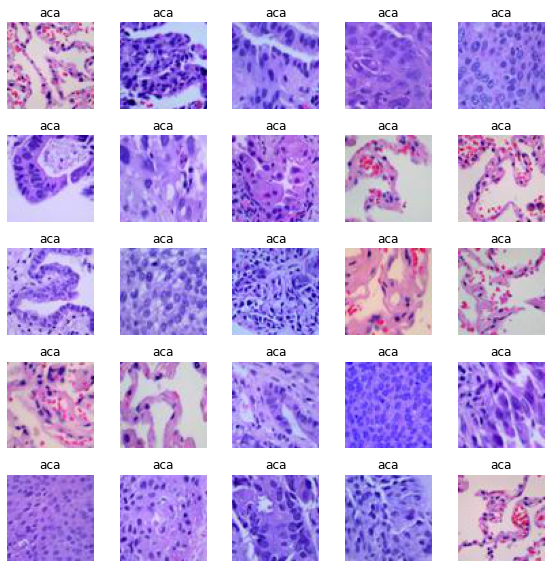

In [ ]:
display_images.display_images(train_iterator)

In [ ]:
%%writefile src/utilities/PatchExtractor.py

# Importing the necessary Packages
import tensorflow as tf
from tensorflow.keras.layers import Layer

# Writing the function
class PatchExtractor(Layer):
  def __init__(self, patch_size):
    super(PatchExtractor, self).__init__()
    self.patch_size = patch_size
    
  def call(self, images):
    batch_size = tf.shape(images)[0]
    patches = tf.image.extract_patches(images=images,
                                       sizes=[1, self.patch_size, self.patch_size, 1],
                                       strides=[1, self.patch_size, self.patch_size, 1],
                                       rates=[1, 1, 1, 1],
                                       padding="VALID")
    patch_dims = patches.shape[-1]
    patches = tf.reshape(patches, [batch_size, -1, patch_dims])
    return patches

Writing src/utilities/PatchExtractor.py


In [ ]:
from src.utilities import PatchExtractor
patches_def = PatchExtractor.PatchExtractor(patch_size=patch_size)

In [ ]:
img, lab = next(train_iterator)
patches = patches_def.call(img)


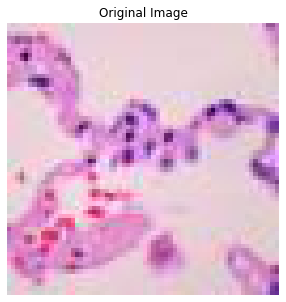

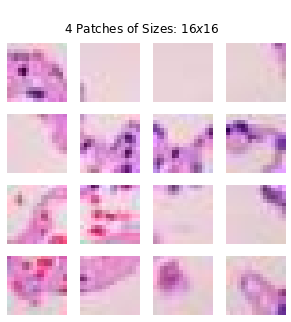

In [ ]:
n = int(np.sqrt(patches.shape[1]))

fig = plt.figure(figsize = (5, 5))
# fig.add_subplot(n+1,n,1)
plt.imshow(img[0])
plt.title('Original Image')
plt.axis('off')
fig1 = plt.figure(figsize = (5, 5))
for i, patch in enumerate(patches[0]):
    fig1.add_subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img)
    plt.suptitle('\n{} Patches of Sizes: ${}x{}$'.format(n, patch_size, patch_size))
    plt.axis("off")
# fig1 = plt.figure(figsize = (20, 20))

In [ ]:
%%writefile src/utilities/PatchEncoder.py

# Importing the necessary Packages
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Embedding

# Writing the function
class PatchEncoder(Layer):
    def __init__(self, num_patches, projection_dim=768):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        w_init = tf.random_normal_initializer()
        class_token = w_init(shape=(1, projection_dim), dtype="float32")
        self.class_token = tf.Variable(initial_value=class_token, trainable=True)
        self.projection = Dense(units=projection_dim)
        self.position_embedding = Embedding(input_dim=num_patches+1, output_dim=projection_dim)

    def call(self, patch):
        batch = tf.shape(patch)[0]
        # reshape the class token embedins
        class_token = tf.tile(self.class_token, multiples = [batch, 1])
        class_token = tf.reshape(class_token, (batch, 1, self.projection_dim))
        # calculate patches embeddings
        patches_embed = self.projection(patch)
        # print('patches_embed_shape: {}'.format(patches_embed.shape))
        patches_embed = tf.concat([patches_embed, class_token], 1)
        # print('patches_embedding_after_class: {}'.format(patches_embed.shape))
        # calcualte positional embeddings
        positions = tf.range(start=0, limit=self.num_patches+1, delta=1)
        positions_embed = self.position_embedding(positions)
        # add both embeddings
        encoded = patches_embed + positions_embed
        return encoded



Writing src/utilities/PatchEncoder.py


In [ ]:
from src.utilities import PatchEncoder
PE_def = PatchEncoder.PatchEncoder(num_patches=num_of_patches)

In [ ]:
embeddings = PE_def.call(patches)
embeddings.shape

TensorShape([32, 17, 768])

In [ ]:
%%writefile src/utilities/MLP.py

# Importing the necessary Packages
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Dropout

# Writing the function
class MLP(Layer):
    def __init__(self, hidden_features, out_features, dropout_rate=0.1):
        super(MLP, self).__init__()
        self.dense1 = Dense(hidden_features, activation=tf.nn.gelu)
        self.dense2 = Dense(out_features)
        self.dropout = Dropout(dropout_rate)

    def call(self, x):
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.dense2(x)
        y = self.dropout(x)
        return y

Writing src/utilities/MLP.py


In [ ]:
from src.utilities import MLP
mlp = MLP.MLP(768 * 2, 768)
y = mlp(embeddings)
y.shape

TensorShape([32, 17, 768])

In [ ]:
%%writefile src/utilities/Block.py

# Importing the necessary Packages
import tensorflow as tf
from tensorflow.keras.layers import Layer, LayerNormalization
from tensorflow.keras.layers import MultiHeadAttention, Add
from src.utilities.MLP import MLP

# Writing the function
class Block(Layer):
    def __init__(self, projection_dim, num_heads=4, dropout_rate=0.1):
        super(Block, self).__init__()
        self.norm1 = LayerNormalization(epsilon=1e-6)
        self.attn = MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=dropout_rate)
        self.norm2 = LayerNormalization(epsilon=1e-6)
        self.mlp = MLP(projection_dim * 2, projection_dim, dropout_rate)

    def call(self, x):
        # Layer normalization 1.
        x1 = self.norm1(x) # encoded_patches
        # print('x1 shape: {}'.format(x1.shape))
        # Create a multi-head attention layer.
        attention_output = self.attn(x1, x1)
        # print('attention_output shape: {}'.format(attention_output.shape))
        # Skip connection 1.
        x2 = Add()([attention_output, x]) #encoded_patches
        # print('x2 shape: {}'.format(x2.shape))
        # Layer normalization 2.
        x3 = self.norm2(x2)
        # MLP.
        x3 = self.mlp(x3)
        # print('x3 shape: {}'.format(x3.shape))
        # Skip connection 2.
        y = Add()([x3, x2])
        # print('y shape: {}'.format(y.shape))
        return y

Writing src/utilities/Block.py


In [ ]:
from src.utilities import Block
block1 = Block.Block(projection_dim = projection_dim, num_heads = num_of_heads)
x = PE_def(patches)
y = block1(x)
y.shape

TensorShape([32, 17, 768])

---
# My Code

---

In [ ]:
# Parameters
target_size = (64, 64)
batch_size = 32
epochs = 5
input_shape = (64, 64, 3)
patch_size = 16
projection_dim=768
num_of_patches = int(input_shape[0]/patch_size * input_shape[1]/patch_size)
num_of_heads = 2

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()


11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
from src.utilities import PatchExtractor

In [ ]:
patches = PatchExtractor.PatchExtractor(patch_size=4)(x_train)

InvalidArgumentError: ignored

In [ ]:
 patches

In [ ]:
x = patche